# Modulation Classification

Developing AutoML Model for AWGN Channel for Modulation Classification. SNR Ratio's(in dB) of Channel are $[-15,-10,-5,0,5,10,15,20,25,30]$.

**Data Generation:**
Data is generated using MatLab's Communication Toolbox for Modulation Schemes QPSK, 16-QAM, 64-QAM for SNR Ratio's (in dB) $[-15,-10,-5,0,5,10,15,20,25,30]$ when signal is transmitted through Channels AWGN and Rayleigh Channels.

**Modulation Classification:**
We will use AutoML to creae a classifer that predicts Modulation Scheme depending on In-Phase and Quadrature-Phase Components at the Receiver's End.

## Imports

### Importing Libraries

We will be using AutoKeras for generating AutoML Models.
Source of Documentation: [https://autokeras.com/](https://autokeras.com/)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as pimg
import seaborn as sns
import scipy.io
import os

# AutoML Libraries
!pip3 install autokeras
import autokeras as ak

# Tensorflow Libraries
import tensorflow as tf
from tensorflow.keras.layers import Dense, Flatten, Conv2D, Input
from tensorflow.keras.models import Model

### Importing Data

Files are uploaded in Google Drive. Notebook is connected to Google Drive

In [2]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive/My\ Drive/Modulation-Classification/Synthetic\ Datasets/AutoML

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive/My Drive/Modulation-Classification/Synthetic Datasets/AutoML


## Processsing Data

Importing Data for all SNR Ratio's

In [3]:
def ImportData(Path):
    ModulationSchemes = os.listdir(Path)

    Dataset = {}
    for scheme in ModulationSchemes:
        DataPath = Path + "/" + scheme
        files = os.listdir(DataPath)
        DataofScheme = {}
        for f in files:
            Data = scipy.io.loadmat(DataPath + "/" + f)
            snr = Data['snr'][0][0]
            rx = Data['rx']
            InPhase, QuadPhase = rx.real, rx.imag
            DataofScheme[snr] = np.append(InPhase, QuadPhase, axis=1)
        Dataset[scheme] = DataofScheme

    return Dataset

## Train and Validation Datasets

**Training:**
- Received Signal with SNR Ratio $30$dB is used for Training for both Channels and all Modulation Schemes.

**Validation:**
- AutoML is validated on Received Signals with SNR Ratio's (in dB) $[-15,-10,-5,0,5,10,15,20,25]$

In [4]:
def ImportDatasets(Channel,L=None):
    if Channel == "AWGN":
        Path =  "../Data/" + Channel
    elif Channel == "Rayleigh":
        Path = "../Data/" + Channel + "/" + str(L)
    Data = ImportData(Path)
    
    Dataset = {}
    Dataset['Classes'] = list(Data.keys())
    OneHotClasses = np.eye(len(Dataset['Classes']))

    Classes = {}
    for i in range(len(Dataset['Classes'])):
        Classes[Dataset['Classes'][i]] = OneHotClasses[i]

    Valid_SNRs = [-15,-10,-5,0,5,10,15,20,25]

    if Channel == "AWGN":
        X_Train, y_Train = np.empty((0,2)), np.empty((0,3))
        X_Valid, y_Valid = {}, {}

        for snr in Valid_SNRs:
            X_Valid[snr] = np.empty((0,2))
            y_Valid[snr] = np.empty((0,3))


        for c in Classes.keys():
            ModData = Data[c]
            SNRs = ModData.keys()
            for snr in SNRs:
                if snr == 30:
                    X = ModData[snr]
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Train = np.append(X_Train,X,axis=0)
                    y_Train = np.append(y_Train,y,axis=0)
                else:
                    X = ModData[snr]
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Valid[snr] = np.append(X_Valid[snr], X, axis=0)
                    y_Valid[snr] = np.append(y_Valid[snr], y, axis=0)

    elif Channel == "Rayleigh":
        X_Train, y_Train = np.empty((0,100,2)), np.empty((0,3))
        X_Valid, y_Valid = {}, {}
        for snr in Valid_SNRs:
            X_Valid[snr] = np.empty((0,100,2))
            y_Valid[snr] = np.empty((0,3))

        for c in Classes.keys():
            ModData = Data[c]
            SNRs = ModData.keys()
            for snr in SNRs:
                if snr == 30:
                    X = ModData[snr]
                    X = X.reshape(-1,100,2)
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Train = np.append(X_Train,X,axis=0)
                    y_Train = np.append(y_Train,y,axis=0)
                else:
                    X = ModData[snr]
                    X = X.reshape(-1,100,2)
                    y = np.repeat(np.expand_dims(Classes[c],axis=0), X.shape[0], axis=0)
                    X_Valid[snr] = np.append(X_Valid[snr], X, axis=0)
                    y_Valid[snr] = np.append(y_Valid[snr], y, axis=0)

    return X_Train, y_Train, X_Valid, y_Valid

## Evaluating Data

In [5]:
def EvaluateData(Model, X_Train, y_Train, X_Valid, y_Valid, SavePath, ValidBatchSize=32):
    Valid_SNR = np.array([-15,-10,-5,0,5,10,15,20,25,30])
    Accuracy = []

    print ("Evaluating Model")
    for snr in Valid_SNR:
        if snr == 30:
            Loss, Acc = Model.evaluate(X_Train, y_Train)
        else:
            Loss, Acc = Model.evaluate(X_Valid[snr], y_Valid[snr], batch_size=ValidBatchSize)
        print ("SNR:", snr, "Accuracy:", Acc)
        Accuracy.append(Acc)

    Accuracy = np.array(Accuracy)

    plt.figure(figsize=(10,10))
    plt.plot(Valid_SNR,Accuracy, color='blue')
    plt.scatter(Valid_SNR,Accuracy, color='red')
    plt.title("Accuracy vs SNR")
    plt.xlabel("SNR")
    plt.ylabel("Accuracy")
    plt.grid()
    plt.savefig(SavePath)
    plt.show()

## AutoML MLP Model for AWGN Channel

For AWGN Channel, Input Dimensions is $(2,)$

#### AWGN Data

In [6]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('AWGN')

#### Creating a MLP Classifier

In [7]:
AWGNClassifier = ak.StructuredDataClassifier(
    overwrite=True,
    max_trials=3,
    loss='categorical_crossentropy',
    num_classes=3)

AWGNClassifier.fit(X_Train, y_Train, epochs=15, batch_size=64, validation_split=0.1)

Trial 3 Complete [00h 00m 13s]
val_accuracy: 1.0

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 00m 44s
INFO:tensorflow:Oracle triggered exit
Epoch 1/15
469/469 [==============================] - 1s 2ms/step - loss: 0.9014 - accuracy: 0.8543
Epoch 2/15
469/469 [==============================] - 1s 2ms/step - loss: 0.9899 - accuracy: 0.5277
Epoch 3/15
469/469 [==============================] - 1s 2ms/step - loss: 0.7479 - accuracy: 0.7067
Epoch 4/15
469/469 [==============================] - 1s 2ms/step - loss: 0.6851 - accuracy: 0.7063
Epoch 5/15
469/469 [==============================] - 1s 2ms/step - loss: 0.6598 - accuracy: 0.6956
Epoch 6/15
469/469 [==============================] - 1s 2ms/step - loss: 0.6438 - accuracy: 0.6953
Epoch 7/15
469/469 [==============================] - 1s 2ms/step - loss: 0.6208 - accuracy: 0.7050
Epoch 8/15
469/469 [==============================] - 1s 2ms/step - loss: 0.5961 - accuracy: 0.7186
Epoch 9/15
469/469 [==============================

#### MLP Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
multi_category_encoding (Mul (None, 2)                 0         
_________________________________________________________________
normalization (Normalization (None, 2)                 5         
_________________________________________________________________
dense (Dense)                (None, 32)                96        
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 32)                1056      
_________________________________________________________________
re_lu_1 (ReLU)               (None, 32)                0     

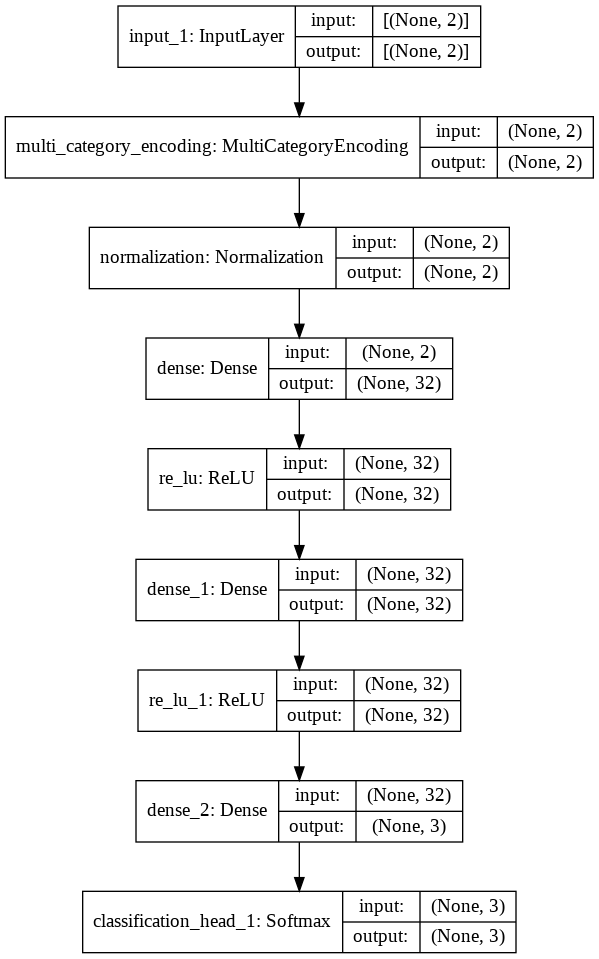

In [8]:
AWGN_Model = AWGNClassifier.export_model()
AWGN_Model.summary()
tf.keras.utils.plot_model(AWGN_Model, to_file='../Models/AWGN_Model_MLP.png', show_shapes=True,show_layer_names=True)

### Training and Evaluating MLP Model

#### Training the MLP Model

In [9]:
AWGN_Model.fit(X_Train, y_Train, epochs=100, batch_size=512, validation_split=0.1,shuffle=True)

Epoch 1/100
53/53 [==============================] - 1s 6ms/step - loss: 1.1792 - accuracy: 0.4149 - val_loss: 0.3844 - val_accuracy: 0.8427
Epoch 2/100
53/53 [==============================] - 0s 3ms/step - loss: 0.4485 - accuracy: 0.8880 - val_loss: 0.6533 - val_accuracy: 0.7413
Epoch 3/100
53/53 [==============================] - 0s 3ms/step - loss: 0.4019 - accuracy: 0.8453 - val_loss: 0.6348 - val_accuracy: 0.7413
Epoch 4/100
53/53 [==============================] - 0s 3ms/step - loss: 0.3900 - accuracy: 0.8459 - val_loss: 0.6251 - val_accuracy: 0.7413
Epoch 5/100
53/53 [==============================] - 0s 3ms/step - loss: 0.3783 - accuracy: 0.8526 - val_loss: 0.6109 - val_accuracy: 0.7413
Epoch 6/100
53/53 [==============================] - 0s 3ms/step - loss: 0.3669 - accuracy: 0.8619 - val_loss: 0.5975 - val_accuracy: 0.7413
Epoch 7/100
53/53 [==============================] - 0s 3ms/step - loss: 0.3551 - accuracy: 0.8737 - val_loss: 0.6059 - val_accuracy: 0.7413
Epoch 8/100
5

#### Evaluate the MLP Model

Evaluating Model
938/938 [==============================] - 2s 2ms/step - loss: 52.2526 - accuracy: 0.3567
SNR: -15 Accuracy: 0.35670000314712524
938/938 [==============================] - 2s 2ms/step - loss: 23.7192 - accuracy: 0.3969
SNR: -10 Accuracy: 0.39693334698677063
938/938 [==============================] - 2s 2ms/step - loss: 10.3159 - accuracy: 0.4859
SNR: -5 Accuracy: 0.4859333336353302
938/938 [==============================] - 2s 2ms/step - loss: 5.0211 - accuracy: 0.5780
SNR: 0 Accuracy: 0.5779666900634766
938/938 [==============================] - 2s 2ms/step - loss: 2.7377 - accuracy: 0.6502
SNR: 5 Accuracy: 0.6502333283424377
938/938 [==============================] - 2s 2ms/step - loss: 1.5557 - accuracy: 0.7258
SNR: 10 Accuracy: 0.725766658782959
938/938 [==============================] - 2s 2ms/step - loss: 0.7874 - accuracy: 0.8022
SNR: 15 Accuracy: 0.8022000193595886
938/938 [==============================] - 2s 2ms/step - loss: 0.3724 - accuracy: 0.8808
SNR: 20 

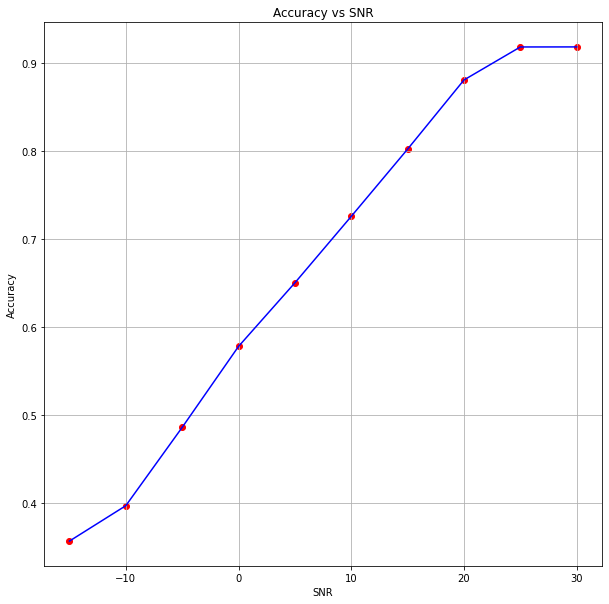

In [10]:
EvaluateData(AWGN_Model, X_Train, y_Train, X_Valid, y_Valid, "../Results/AWGN_Accuracy_MLP.jpg")

#### Save MLP Model

In [11]:
AWGN_Model.save("../Models/AWGN_MLP.h5")

## AutoML CNN Model for AWGN Channel

For AWGN Channel, Input Dimensions is $(100,2)$

#### AWGN Data

In [12]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('AWGN')

X_Train = X_Train.reshape(-1,100,2)
y_Train = y_Train[::100]
for snr in [-15,-10,-5,0,5,10,15,20,25]:
    X_Valid[snr] = X_Valid[snr].reshape(-1,100,2)
    y_Valid[snr] = y_Valid[snr][::100]

#### Creating a CNN Classifier

In [13]:
AWGNClassifier = ak.ImageClassifier(
    overwrite=True,
    max_trials=1,
    loss='categorical_crossentropy',
    num_classes=3)

AWGNClassifier.fit(X_Train, y_Train, epochs=15, batch_size=64, validation_split=0.1)

Trial 1 Complete [00h 00m 04s]
val_loss: 0.46384304761886597

Best val_loss So Far: 0.46384304761886597
Total elapsed time: 00h 00m 04s
INFO:tensorflow:Oracle triggered exit
Epoch 1/15
5/5 [==============================] - 0s 13ms/step - loss: 1.3697 - accuracy: 0.3329
Epoch 2/15
5/5 [==============================] - 0s 4ms/step - loss: 1.0391 - accuracy: 0.4923
Epoch 3/15
5/5 [==============================] - 0s 4ms/step - loss: 1.0384 - accuracy: 0.1801
Epoch 4/15
5/5 [==============================] - 0s 4ms/step - loss: 1.0817 - accuracy: 0.1476
Epoch 5/15
5/5 [==============================] - 0s 4ms/step - loss: 1.1225 - accuracy: 0.1476
Epoch 6/15
5/5 [==============================] - 0s 4ms/step - loss: 1.1118 - accuracy: 0.1476
Epoch 7/15
5/5 [==============================] - 0s 4ms/step - loss: 1.0775 - accuracy: 0.1476
Epoch 8/15
5/5 [==============================] - 0s 4ms/step - loss: 1.0293 - accuracy: 0.1476
Epoch 9/15
5/5 [==============================] - 0s 4ms/

#### CNN Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 100, 2)            0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 100, 2, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 100, 2, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 2, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 2, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 1, 64)         0     

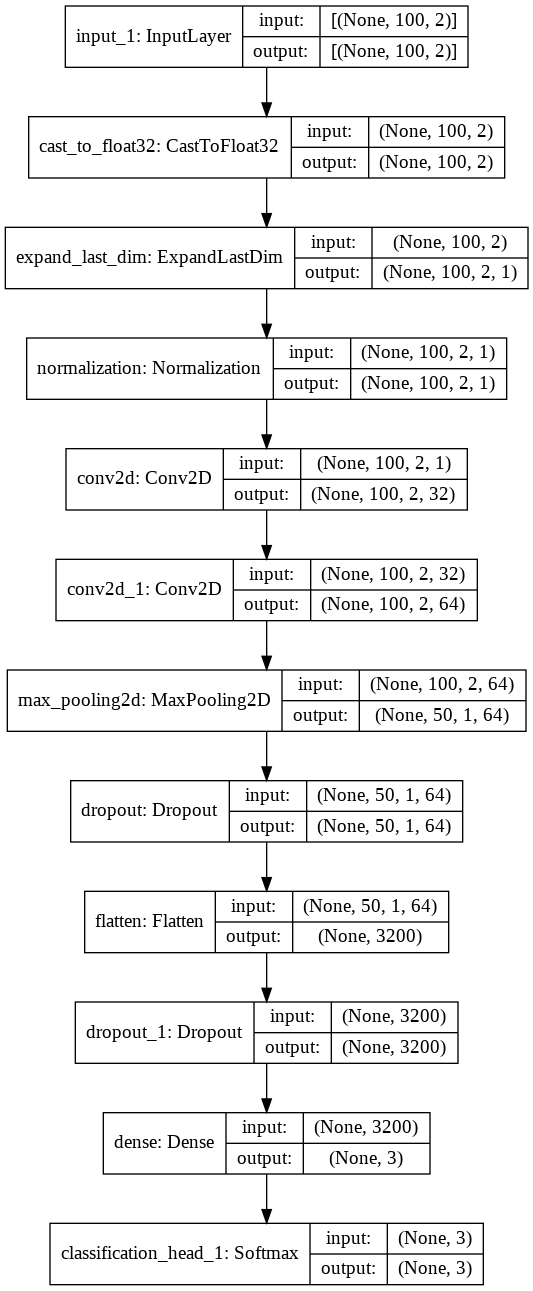

In [14]:
AWGN_Model = AWGNClassifier.export_model()
AWGN_Model.summary()
tf.keras.utils.plot_model(AWGN_Model, to_file='../Models/AWGN_Model_CNN.png', show_shapes=True,show_layer_names=True)

### Training and Evaluating CNN Model

#### Training the CNN Model

In [15]:
AWGN_Model.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.1,shuffle=True)

Epoch 1/25
17/17 [==============================] - 1s 17ms/step - loss: 0.7121 - accuracy: 0.8037 - val_loss: 0.2159 - val_accuracy: 1.0000
Epoch 2/25
17/17 [==============================] - 0s 5ms/step - loss: 0.5597 - accuracy: 0.9037 - val_loss: 0.3579 - val_accuracy: 1.0000
Epoch 3/25
17/17 [==============================] - 0s 5ms/step - loss: 0.3555 - accuracy: 0.9778 - val_loss: 0.1179 - val_accuracy: 1.0000
Epoch 4/25
17/17 [==============================] - 0s 5ms/step - loss: 0.1486 - accuracy: 0.9963 - val_loss: 0.0093 - val_accuracy: 1.0000
Epoch 5/25
17/17 [==============================] - 0s 5ms/step - loss: 0.0663 - accuracy: 1.0000 - val_loss: 0.0054 - val_accuracy: 1.0000
Epoch 6/25
17/17 [==============================] - 0s 5ms/step - loss: 0.0357 - accuracy: 0.9963 - val_loss: 5.5453e-04 - val_accuracy: 1.0000
Epoch 7/25
17/17 [==============================] - 0s 5ms/step - loss: 0.0157 - accuracy: 1.0000 - val_loss: 0.0044 - val_accuracy: 1.0000
Epoch 8/25
17/1

#### Evaluate the CNN Model

Evaluating Model
10/10 [==============================] - 0s 4ms/step - loss: 39.4834 - accuracy: 0.3333
SNR: -15 Accuracy: 0.3333333432674408
10/10 [==============================] - 0s 2ms/step - loss: 14.0908 - accuracy: 0.3333
SNR: -10 Accuracy: 0.3333333432674408
10/10 [==============================] - 0s 3ms/step - loss: 2.9278 - accuracy: 0.6600
SNR: -5 Accuracy: 0.6600000262260437
10/10 [==============================] - 0s 2ms/step - loss: 0.1576 - accuracy: 0.9167
SNR: 0 Accuracy: 0.9166666865348816
10/10 [==============================] - 0s 2ms/step - loss: 0.0030 - accuracy: 1.0000
SNR: 5 Accuracy: 1.0
10/10 [==============================] - 0s 2ms/step - loss: 6.2303e-04 - accuracy: 1.0000
SNR: 10 Accuracy: 1.0
10/10 [==============================] - 0s 4ms/step - loss: 4.3464e-04 - accuracy: 1.0000
SNR: 15 Accuracy: 1.0
10/10 [==============================] - 0s 2ms/step - loss: 3.6973e-04 - accuracy: 1.0000
SNR: 20 Accuracy: 1.0
10/10 [==============================

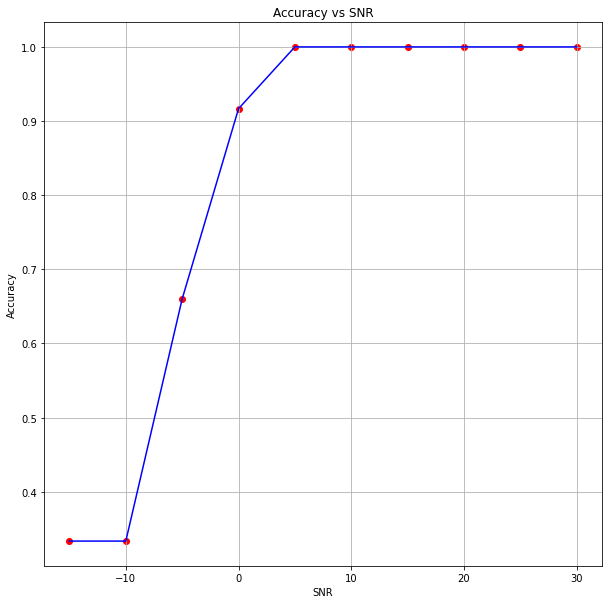

In [16]:
EvaluateData(AWGN_Model, X_Train, y_Train, X_Valid, y_Valid, "../Results/AWGN_Accuracy_CNN.jpg")

#### Save CNN  Model

In [17]:
AWGN_Model.save("../Models/AWGN_CNN.h5")

## AutoML CNN Model for Rayleigh Channel of Channel-Length = 2

For Rayleigh Channel, Input Dimensions is (100,2)

#### Rayleigh Data

In [18]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=2)

#### Creating a CNN Classifier

In [19]:
RayleighClassifier = ak.ImageClassifier(
    overwrite=True,
    max_trials=1,
    loss='categorical_crossentropy',
    num_classes=3)

RayleighClassifier.fit(X_Train, y_Train, epochs=5, batch_size=16, validation_split=0.1)

Trial 1 Complete [00h 00m 14s]
val_loss: 3.9500017010141164e-05

Best val_loss So Far: 3.9500017010141164e-05
Total elapsed time: 00h 00m 14s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
938/938 [==============================] - 3s 3ms/step - loss: 0.3352 - accuracy: 0.9772
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 1.0177 - accuracy: 0.2613
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.6979 - accuracy: 0.7204
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.2346 - accuracy: 0.9127
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1230 - accuracy: 0.9492
INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


#### CNN Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 100, 2)            0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 100, 2, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 100, 2, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 2, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 2, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 1, 64)         0     

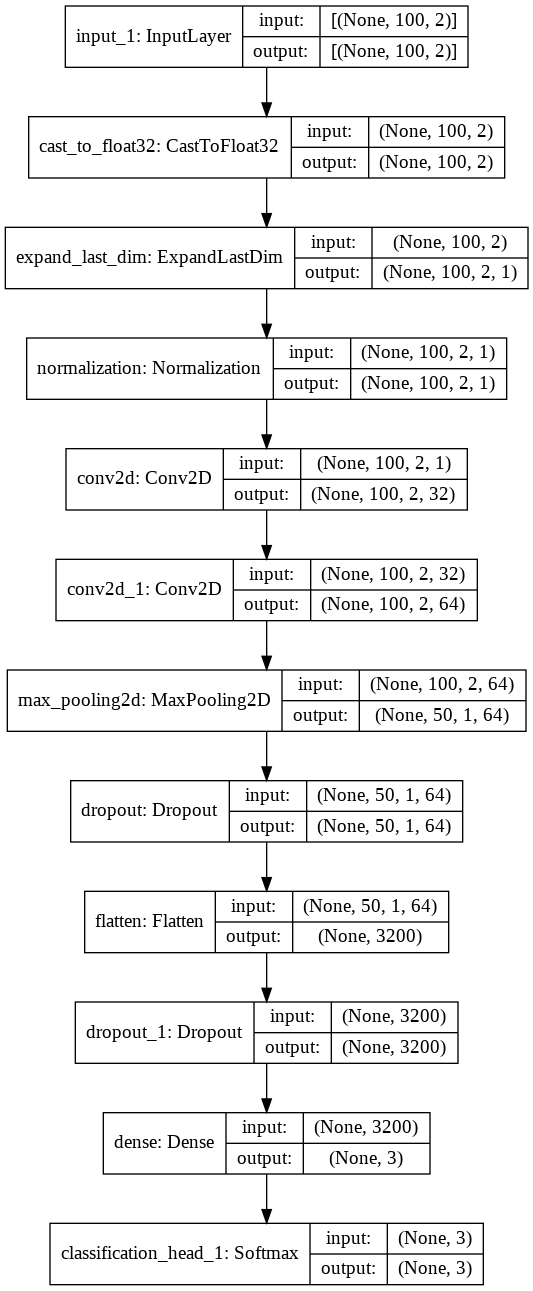

In [20]:
Rayleigh_Model = RayleighClassifier.export_model()
Rayleigh_Model.summary()
tf.keras.utils.plot_model(Rayleigh_Model, to_file='../Models/Rayleigh_Model_L=2_CNN.png', show_shapes=True,show_layer_names=True)

### Training and Evaluating CNN Model

#### Training the CNN Model

In [21]:
Rayleigh_Model.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.25,shuffle=True)

Epoch 1/25
704/704 [==============================] - 3s 4ms/step - loss: 0.1835 - accuracy: 0.9609 - val_loss: 0.0011 - val_accuracy: 1.0000
Epoch 2/25
704/704 [==============================] - 2s 3ms/step - loss: 7.2654e-04 - accuracy: 1.0000 - val_loss: 1.0671e-04 - val_accuracy: 1.0000
Epoch 3/25
704/704 [==============================] - 2s 3ms/step - loss: 2.4528e-04 - accuracy: 1.0000 - val_loss: 4.6022e-05 - val_accuracy: 1.0000
Epoch 4/25
704/704 [==============================] - 2s 3ms/step - loss: 2.4933e-04 - accuracy: 0.9999 - val_loss: 2.1161e-05 - val_accuracy: 1.0000
Epoch 5/25
704/704 [==============================] - 2s 3ms/step - loss: 9.6792e-05 - accuracy: 1.0000 - val_loss: 9.9080e-06 - val_accuracy: 1.0000
Epoch 6/25
704/704 [==============================] - 2s 3ms/step - loss: 4.6406e-05 - accuracy: 1.0000 - val_loss: 2.2870e-05 - val_accuracy: 1.0000
Epoch 7/25
704/704 [==============================] - 2s 3ms/step - loss: 2.8590e-05 - accuracy: 1.0000 - va

#### Evaluate the CNN Model

Evaluating Model
469/469 [==============================] - 1s 2ms/step - loss: 23.9563 - accuracy: 0.3415
SNR: -15 Accuracy: 0.3415333330631256
469/469 [==============================] - 1s 2ms/step - loss: 1.8342 - accuracy: 0.7747
SNR: -10 Accuracy: 0.774733304977417
469/469 [==============================] - 1s 2ms/step - loss: 0.0175 - accuracy: 0.9950
SNR: -5 Accuracy: 0.9950000047683716
469/469 [==============================] - 1s 2ms/step - loss: 9.0477e-04 - accuracy: 0.9999
SNR: 0 Accuracy: 0.9999333620071411
469/469 [==============================] - 1s 2ms/step - loss: 8.5173e-08 - accuracy: 1.0000
SNR: 5 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 1.7444e-08 - accuracy: 1.0000
SNR: 10 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 1.3208e-08 - accuracy: 1.0000
SNR: 15 Accuracy: 1.0
469/469 [==============================] - 1s 2ms/step - loss: 1.6729e-08 - accuracy: 1.0000
SNR: 20 Accuracy: 1.0
469/469 [======

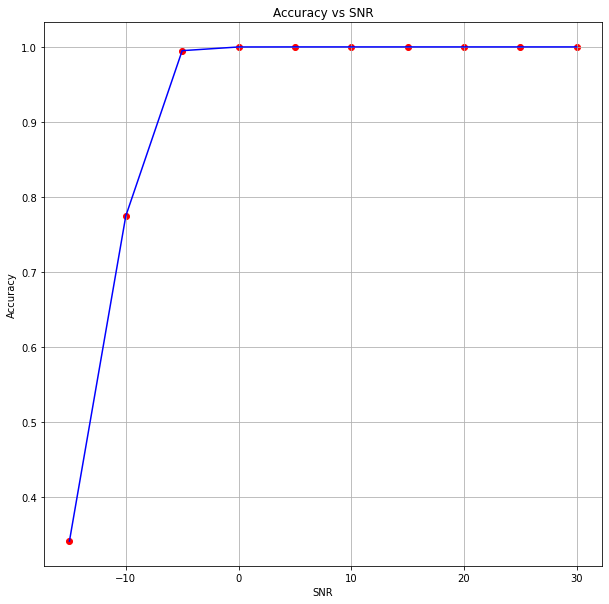

In [22]:
EvaluateData(Rayleigh_Model, X_Train, y_Train, X_Valid, y_Valid, "../Results/Rayleigh_Accuracy_L=2_CNN.jpg")

#### Save CNN Model

In [23]:
Rayleigh_Model.save("../Models/Rayleigh_L=2_CNN.h5")

## AutoML CNN Model for Rayleigh Channel of Channel-Length = 3

For Rayleigh Channel, Input Dimensions is (100,2)

#### Rayleigh Data

In [24]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=3)

#### Creating a CNN Classifier

In [25]:
RayleighClassifier = ak.ImageClassifier(
    overwrite=True,
    max_trials=1,
    loss='categorical_crossentropy',
    num_classes=3)

RayleighClassifier.fit(X_Train, y_Train, epochs=5, batch_size=16, validation_split=0.1)

Trial 1 Complete [00h 00m 14s]
val_loss: 1.0008723165810807e-06

Best val_loss So Far: 1.0008723165810807e-06
Total elapsed time: 00h 00m 14s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
938/938 [==============================] - 3s 3ms/step - loss: 0.1047 - accuracy: 0.9801
Epoch 2/5
938/938 [==============================] - 3s 3ms/step - loss: 0.9058 - accuracy: 0.8861
Epoch 3/5
938/938 [==============================] - 3s 3ms/step - loss: 0.5232 - accuracy: 0.8534
Epoch 4/5
938/938 [==============================] - 3s 3ms/step - loss: 0.5159 - accuracy: 0.8862
Epoch 5/5
938/938 [==============================] - 3s 3ms/step - loss: 0.6435 - accuracy: 0.8744
INFO:tensorflow:Assets written to: ./image_classifier/best_model/assets


#### CNN Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 100, 2)            0         
_________________________________________________________________
expand_last_dim (ExpandLastD (None, 100, 2, 1)         0         
_________________________________________________________________
normalization (Normalization (None, 100, 2, 1)         3         
_________________________________________________________________
conv2d (Conv2D)              (None, 100, 2, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 100, 2, 64)        18496     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 50, 1, 64)         0     

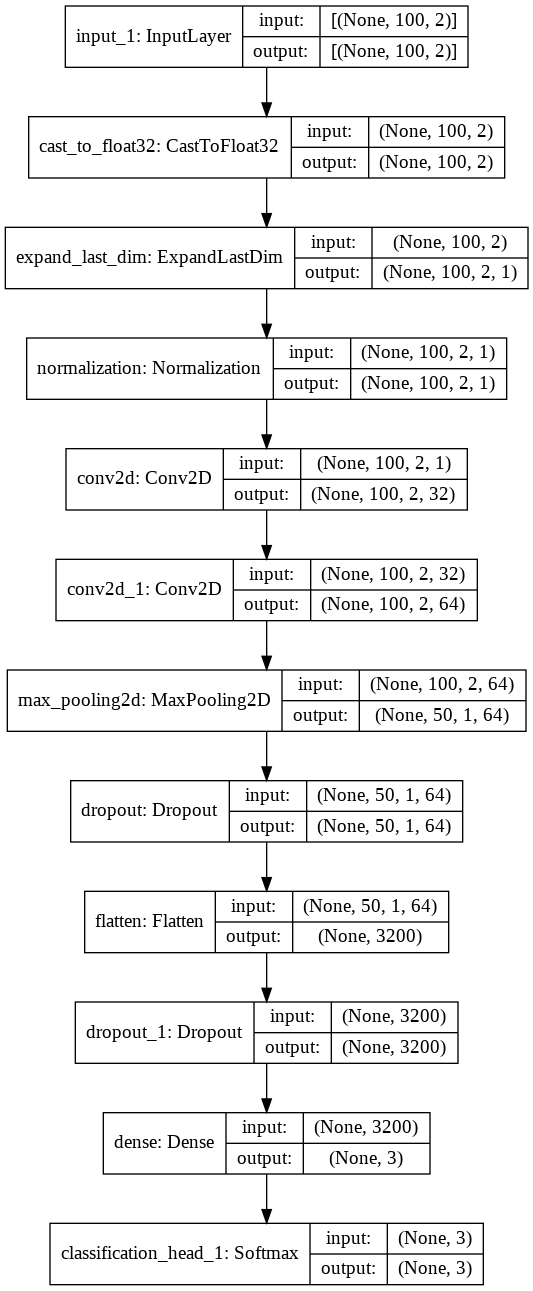

In [26]:
Rayleigh_Model = RayleighClassifier.export_model()
Rayleigh_Model.summary()
tf.keras.utils.plot_model(Rayleigh_Model, to_file='../Models/Rayleigh_Model_L=3_CNN.png', show_shapes=True,show_layer_names=True)

### Training and Evaluating CNN Model

#### Training the CNN Model

In [27]:
Rayleigh_Model.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.25,shuffle=True)

Epoch 1/25
704/704 [==============================] - 3s 4ms/step - loss: 0.3759 - accuracy: 0.9111 - val_loss: 0.0096 - val_accuracy: 1.0000
Epoch 2/25
704/704 [==============================] - 2s 3ms/step - loss: 0.0242 - accuracy: 0.9921 - val_loss: 0.0055 - val_accuracy: 1.0000
Epoch 3/25
704/704 [==============================] - 2s 3ms/step - loss: 0.0136 - accuracy: 0.9956 - val_loss: 0.0027 - val_accuracy: 1.0000
Epoch 4/25
704/704 [==============================] - 2s 3ms/step - loss: 0.0098 - accuracy: 0.9966 - val_loss: 0.0015 - val_accuracy: 1.0000
Epoch 5/25
704/704 [==============================] - 2s 3ms/step - loss: 0.0077 - accuracy: 0.9977 - val_loss: 7.1094e-04 - val_accuracy: 1.0000
Epoch 6/25
704/704 [==============================] - 2s 3ms/step - loss: 0.0066 - accuracy: 0.9978 - val_loss: 0.0013 - val_accuracy: 1.0000
Epoch 7/25
704/704 [==============================] - 2s 3ms/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 6.0262e-04 - val_accuracy: 1.000

#### Evaluate the CNN Model

Evaluating Model
469/469 [==============================] - 1s 2ms/step - loss: 387.8930 - accuracy: 0.3333
SNR: -15 Accuracy: 0.3333333432674408
469/469 [==============================] - 1s 2ms/step - loss: 169.1480 - accuracy: 0.3333
SNR: -10 Accuracy: 0.3333333432674408
469/469 [==============================] - 1s 2ms/step - loss: 62.4348 - accuracy: 0.3333
SNR: -5 Accuracy: 0.3333333432674408
469/469 [==============================] - 1s 2ms/step - loss: 17.2900 - accuracy: 0.4352
SNR: 0 Accuracy: 0.4352000057697296
469/469 [==============================] - 1s 2ms/step - loss: 2.2809 - accuracy: 0.7415
SNR: 5 Accuracy: 0.7415333390235901
469/469 [==============================] - 1s 2ms/step - loss: 0.0387 - accuracy: 0.9875
SNR: 10 Accuracy: 0.9874666929244995
469/469 [==============================] - 1s 2ms/step - loss: 7.4576e-04 - accuracy: 0.9997
SNR: 15 Accuracy: 0.9997333288192749
469/469 [==============================] - 1s 2ms/step - loss: 1.0460e-04 - accuracy: 1.000

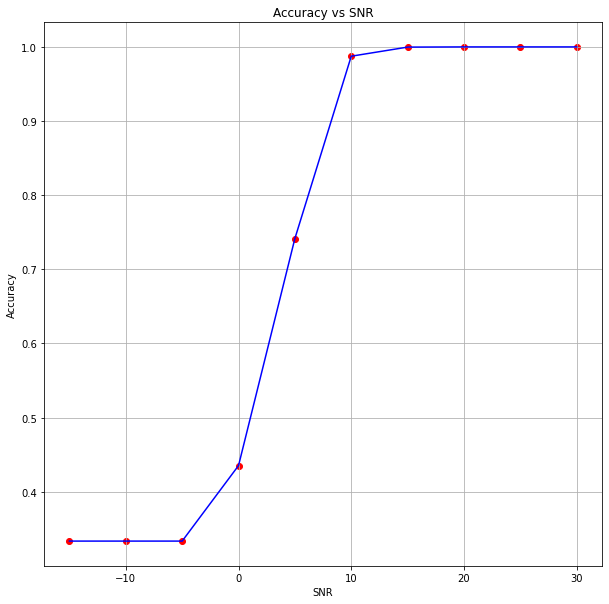

In [28]:
EvaluateData(Rayleigh_Model, X_Train, y_Train, X_Valid, y_Valid, "../Results/Rayleigh_Accuracy_L=3_CNN.jpg")

#### Save CNN Model

In [29]:
Rayleigh_Model.save("../Models/Rayleigh_L=3_CNN.h5")

## AutoML RNN Model for Rayleigh Channel of Channel-Length = 2

For Rayleigh Channel, Input Dimensions is (100,2)

#### Rayleigh Data

In [30]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=2)

#### Creating a RNN Classifier

In [31]:
input_node = ak.Input()
rnn_node = ak.RNNBlock(return_sequences=True,
                       bidirectional=False,
                       num_layers=2,
                       layer_type='lstm')(input_node)
dense_node = ak.DenseBlock()(rnn_node)
output_node = ak.ClassificationHead(num_classes=3,
                                    loss='categorical_crossentropy')(dense_node)

RayleighClassifier = ak.AutoModel(inputs=input_node,
                                  outputs=output_node, 
                                  overwrite=True,
                                  max_trials=3)

RayleighClassifier.fit(X_Train, y_Train, epochs=5, batch_size=16, validation_split=0.1)

Trial 3 Complete [00h 00m 39s]
val_loss: 0.02412736788392067

Best val_loss So Far: 0.0006723141996189952
Total elapsed time: 00h 02m 01s
INFO:tensorflow:Oracle triggered exit
Epoch 1/5
938/938 [==============================] - 10s 8ms/step - loss: 0.2684 - accuracy: 0.9522
Epoch 2/5
938/938 [==============================] - 7s 8ms/step - loss: 0.8190 - accuracy: 0.7725
Epoch 3/5
938/938 [==============================] - 7s 8ms/step - loss: 0.5234 - accuracy: 0.8674
Epoch 4/5
938/938 [==============================] - 7s 8ms/step - loss: 0.2946 - accuracy: 0.9082
Epoch 5/5
938/938 [==============================] - 7s 8ms/step - loss: 0.6540 - accuracy: 0.8852


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


#### RNN Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 100, 2)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 2)            40        
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 2)            40        
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                6432      
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0     

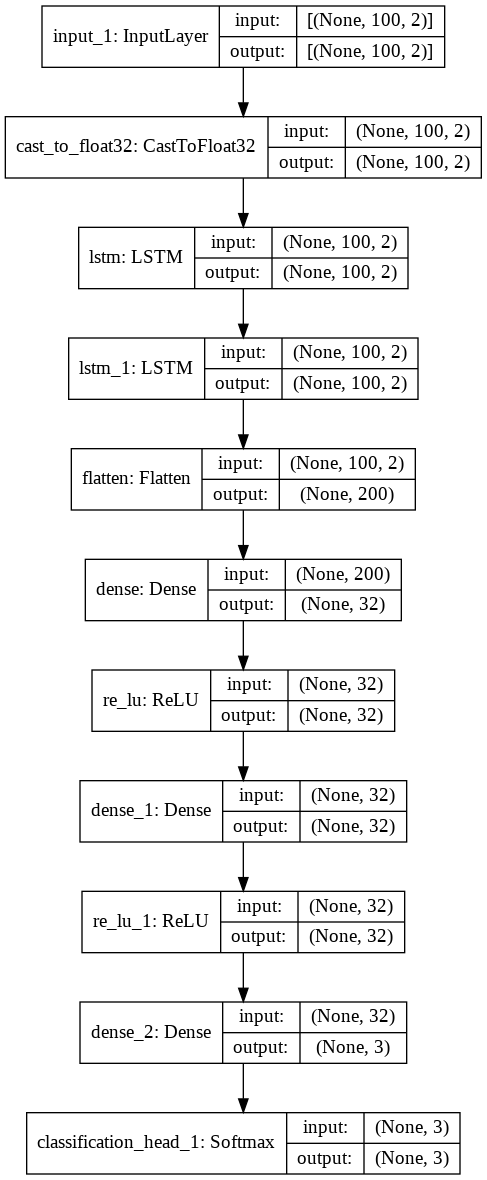

In [32]:
Rayleigh_Model = RayleighClassifier.export_model()
Rayleigh_Model.summary()
tf.keras.utils.plot_model(Rayleigh_Model, to_file='../Models/Rayleigh_Model_L=2_RNN.png', show_shapes=True,show_layer_names=True)

### Training and Evaluating RNN Model

#### Training the RNN Model

In [33]:
Rayleigh_Model.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.25,shuffle=True)

Epoch 1/25
704/704 [==============================] - 10s 10ms/step - loss: 0.2154 - accuracy: 0.9265 - val_loss: 0.1840 - val_accuracy: 0.9357
Epoch 2/25
704/704 [==============================] - 6s 9ms/step - loss: 0.0163 - accuracy: 0.9952 - val_loss: 0.0364 - val_accuracy: 0.9885
Epoch 3/25
704/704 [==============================] - 6s 9ms/step - loss: 0.0081 - accuracy: 0.9973 - val_loss: 0.0216 - val_accuracy: 0.9928
Epoch 4/25
704/704 [==============================] - 6s 9ms/step - loss: 0.0048 - accuracy: 0.9987 - val_loss: 0.0552 - val_accuracy: 0.9803
Epoch 5/25
704/704 [==============================] - 6s 9ms/step - loss: 0.0038 - accuracy: 0.9988 - val_loss: 0.0202 - val_accuracy: 0.9925
Epoch 6/25
704/704 [==============================] - 6s 9ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.0116 - val_accuracy: 0.9973
Epoch 7/25
704/704 [==============================] - 6s 9ms/step - loss: 5.1456e-04 - accuracy: 0.9998 - val_loss: 0.0111 - val_accuracy: 0.9973


#### Evaluate the RNN Model

Evaluating Model
469/469 [==============================] - 2s 4ms/step - loss: 22.0419 - accuracy: 0.3333
SNR: -15 Accuracy: 0.3333333432674408
469/469 [==============================] - 2s 4ms/step - loss: 12.1696 - accuracy: 0.4259
SNR: -10 Accuracy: 0.4259333312511444
469/469 [==============================] - 2s 4ms/step - loss: 3.2586 - accuracy: 0.7682
SNR: -5 Accuracy: 0.7681999802589417
469/469 [==============================] - 2s 4ms/step - loss: 0.1396 - accuracy: 0.9769
SNR: 0 Accuracy: 0.9769333600997925
469/469 [==============================] - 2s 4ms/step - loss: 0.0064 - accuracy: 0.9981
SNR: 5 Accuracy: 0.9980666637420654
469/469 [==============================] - 2s 4ms/step - loss: 0.0012 - accuracy: 0.9998
SNR: 10 Accuracy: 0.9998000264167786
469/469 [==============================] - 2s 5ms/step - loss: 9.7480e-04 - accuracy: 0.9998
SNR: 15 Accuracy: 0.9998000264167786
469/469 [==============================] - 2s 4ms/step - loss: 0.0015 - accuracy: 0.9997
SNR: 2

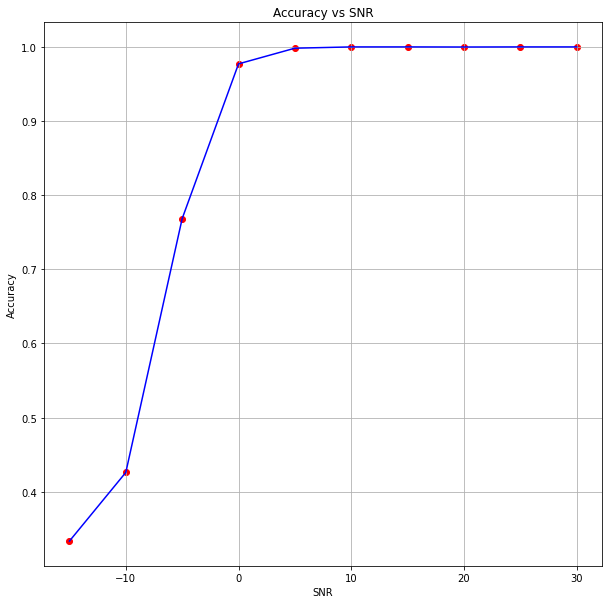

In [34]:
EvaluateData(Rayleigh_Model, X_Train, y_Train, X_Valid, y_Valid, "../Results/Rayleigh_Accuracy_L=2_RNN.jpg")

#### Save RNN Model

In [35]:
Rayleigh_Model.save("../Models/Rayleigh_L=2_RNN.h5")

## AutoML RNN Model for Rayleigh Channel of Channel-Length = 3

For Rayleigh Channel, Input Dimensions is (100,2)

#### Rayleigh Data

In [ ]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=3)

#### Creating a RNN Classifier

In [37]:
input_node = ak.Input()
rnn_node = ak.RNNBlock(return_sequences=True,
                       bidirectional=False,
                       num_layers=2,
                       layer_type='lstm')(input_node)
dense_node = ak.DenseBlock()(rnn_node)
output_node = ak.ClassificationHead(num_classes=3,
                                    loss='categorical_crossentropy')(dense_node)

RayleighClassifier = ak.AutoModel(inputs=input_node,
                                  outputs=output_node, 
                                  overwrite=True,
                                  max_trials=3)

RayleighClassifier.fit(X_Train, y_Train, epochs=5, batch_size=16, validation_split=0.1)

Trial 3 Complete [00h 00m 39s]
val_loss: 7.484073285013437e-05

Best val_loss So Far: 1.0169415872951504e-05
Total elapsed time: 00h 01m 58s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Epoch 1/5
938/938 [==============================] - 10s 8ms/step - loss: 0.2391 - accuracy: 0.9640
Epoch 2/5
938/938 [==============================] - 7s 8ms/step - loss: 0.7715 - accuracy: 0.8045
Epoch 3/5
938/938 [==============================] - 7s 8ms/step - loss: 0.8781 - accuracy: 0.7968
Epoch 4/5
938/938 [==============================] - 7s 8ms/step - loss: 0.5292 - accuracy: 0.8469
Epoch 5/5
938/938 [==============================] - 7s 8ms/step - loss: 0.5441 - accuracy: 0.8569


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


INFO:tensorflow:Assets written to: ./auto_model/best_model/assets


#### RNN Model Summary

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2)]          0         
_________________________________________________________________
cast_to_float32 (CastToFloat (None, 100, 2)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100, 2)            40        
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 2)            40        
_________________________________________________________________
flatten (Flatten)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                6432      
_________________________________________________________________
re_lu (ReLU)                 (None, 32)                0     

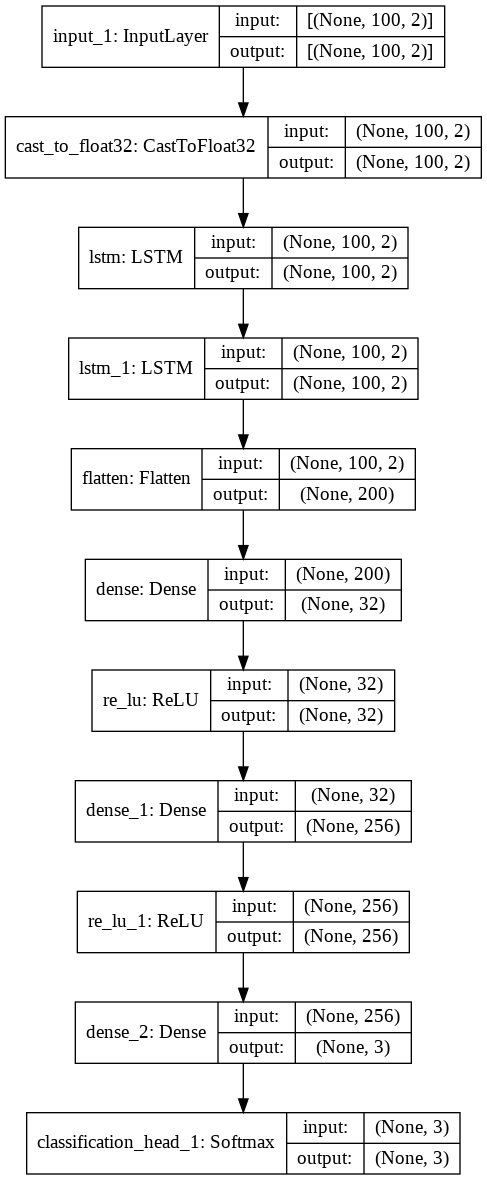

In [38]:
Rayleigh_Model = RayleighClassifier.export_model()
Rayleigh_Model.summary()
tf.keras.utils.plot_model(Rayleigh_Model, to_file='../Models/Rayleigh_Model_L=3_RNN.png', show_shapes=True,show_layer_names=True)

### Training and Evaluating RNN Model

#### Training the RNN Model

In [39]:
Rayleigh_Model.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.25,shuffle=True)

Epoch 1/25
704/704 [==============================] - 10s 10ms/step - loss: 1.0364 - accuracy: 0.6589 - val_loss: 0.2274 - val_accuracy: 0.8963
Epoch 2/25
704/704 [==============================] - 6s 9ms/step - loss: 0.2931 - accuracy: 0.8773 - val_loss: 0.1447 - val_accuracy: 0.9488
Epoch 3/25
704/704 [==============================] - 6s 9ms/step - loss: 0.2286 - accuracy: 0.9078 - val_loss: 0.0673 - val_accuracy: 0.9755
Epoch 4/25
704/704 [==============================] - 6s 9ms/step - loss: 0.1763 - accuracy: 0.9296 - val_loss: 0.0079 - val_accuracy: 0.9979
Epoch 5/25
704/704 [==============================] - 6s 9ms/step - loss: 0.1172 - accuracy: 0.9540 - val_loss: 9.6246e-04 - val_accuracy: 1.0000
Epoch 6/25
704/704 [==============================] - 6s 9ms/step - loss: 0.0875 - accuracy: 0.9665 - val_loss: 0.0018 - val_accuracy: 0.9997
Epoch 7/25
704/704 [==============================] - 6s 9ms/step - loss: 0.0750 - accuracy: 0.9704 - val_loss: 0.0018 - val_accuracy: 0.9995


#### Evaluate the RNN Model

Evaluating Model
469/469 [==============================] - 2s 4ms/step - loss: 84.4570 - accuracy: 0.3333
SNR: -15 Accuracy: 0.3333333432674408
469/469 [==============================] - 2s 4ms/step - loss: 48.0394 - accuracy: 0.3333
SNR: -10 Accuracy: 0.3333333432674408
469/469 [==============================] - 2s 4ms/step - loss: 24.4694 - accuracy: 0.3343
SNR: -5 Accuracy: 0.3343333303928375
469/469 [==============================] - 2s 4ms/step - loss: 9.2136 - accuracy: 0.4835
SNR: 0 Accuracy: 0.4835333228111267
469/469 [==============================] - 2s 4ms/step - loss: 2.8559 - accuracy: 0.6653
SNR: 5 Accuracy: 0.6653333306312561
469/469 [==============================] - 2s 5ms/step - loss: 0.4651 - accuracy: 0.8841
SNR: 10 Accuracy: 0.884066641330719
469/469 [==============================] - 2s 4ms/step - loss: 0.0661 - accuracy: 0.9772
SNR: 15 Accuracy: 0.9771999716758728
469/469 [==============================] - 2s 4ms/step - loss: 0.0305 - accuracy: 0.9890
SNR: 20 Ac

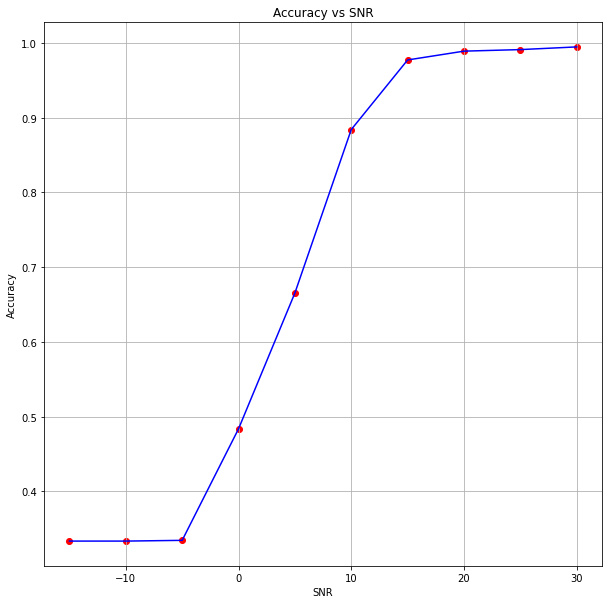

In [40]:
EvaluateData(Rayleigh_Model, X_Train, y_Train, X_Valid, y_Valid, "../Results/Rayleigh_Accuracy_L=3_RNN.jpg")

#### Save RNN Model

In [41]:
Rayleigh_Model.save("../Models/Rayleigh_L=3_RNN.h5")

## CNN Model for Rayleigh Data

This part of the code is written to verify the results with CNN.

In [42]:
def CreateCNNModel():
    tf.keras.backend.clear_session()
    In = Input(shape=(100,2,1))
    x = Conv2D(filters=64,kernel_size=(3,1),activation='relu')(In)
    x = Conv2D(filters=16,kernel_size=(3,2),activation='relu')(x)
    x = Flatten()(x)
    x = Dense(128,activation='relu')(x)
    Ou = Dense(3,activation='softmax')(x)

    model = Model(In,Ou)
    model.compile(optimizer="Adam", loss="categorical_crossentropy", metrics=["acc"])

    return model

### Rayleigh Fading of Channel Length = 2

Data Generation

In [43]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=2)
X_Train = np.expand_dims(X_Train,axis=-1)
for snr in [-15,-10,-5,0,5,10,15,20,25]:
    X_Valid[snr] = np.expand_dims(X_Valid[snr],axis=-1)

Model Creation

In [44]:
CNNModel2 = CreateCNNModel()
CNNModel2.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 2, 64)         256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 1, 16)         6160      
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 203,539
Trainable params: 203,539
Non-trainable params: 0
_______________________________________________________

Training

In [45]:
CNNModel2.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.25,shuffle=True)

Epoch 1/25
704/704 [==============================] - 3s 4ms/step - loss: 0.1956 - acc: 0.9003 - val_loss: 2.3099e-04 - val_acc: 1.0000
Epoch 2/25
704/704 [==============================] - 2s 3ms/step - loss: 3.9659e-05 - acc: 1.0000 - val_loss: 6.1370e-04 - val_acc: 1.0000
Epoch 3/25
704/704 [==============================] - 2s 3ms/step - loss: 1.6390e-05 - acc: 1.0000 - val_loss: 4.6751e-05 - val_acc: 1.0000
Epoch 4/25
704/704 [==============================] - 2s 3ms/step - loss: 7.3670e-06 - acc: 1.0000 - val_loss: 2.5791e-05 - val_acc: 1.0000
Epoch 5/25
704/704 [==============================] - 2s 3ms/step - loss: 3.6038e-06 - acc: 1.0000 - val_loss: 1.5444e-05 - val_acc: 1.0000
Epoch 6/25
704/704 [==============================] - 2s 3ms/step - loss: 1.9795e-06 - acc: 1.0000 - val_loss: 1.4731e-05 - val_acc: 1.0000
Epoch 7/25
704/704 [==============================] - 2s 3ms/step - loss: 1.5018e-06 - acc: 1.0000 - val_loss: 7.9848e-06 - val_acc: 1.0000
Epoch 8/25
704/704 [====

Evaluating

Evaluating Model
469/469 [==============================] - 1s 2ms/step - loss: 14.5687 - acc: 0.4059
SNR: -15 Accuracy: 0.40593332052230835
469/469 [==============================] - 1s 2ms/step - loss: 3.1678 - acc: 0.5719
SNR: -10 Accuracy: 0.5719333291053772
469/469 [==============================] - 1s 2ms/step - loss: 0.0519 - acc: 0.9843
SNR: -5 Accuracy: 0.9842666387557983
469/469 [==============================] - 1s 2ms/step - loss: 9.4391e-04 - acc: 0.9997
SNR: 0 Accuracy: 0.9997333288192749
469/469 [==============================] - 1s 2ms/step - loss: 1.6613e-04 - acc: 0.9999
SNR: 5 Accuracy: 0.9999333620071411
469/469 [==============================] - 1s 2ms/step - loss: 1.2477e-04 - acc: 0.9999
SNR: 10 Accuracy: 0.9999333620071411
469/469 [==============================] - 1s 2ms/step - loss: 7.1508e-05 - acc: 0.9999
SNR: 15 Accuracy: 0.9999333620071411
469/469 [==============================] - 1s 2ms/step - loss: 1.0827e-05 - acc: 1.0000
SNR: 20 Accuracy: 1.0
469/469 

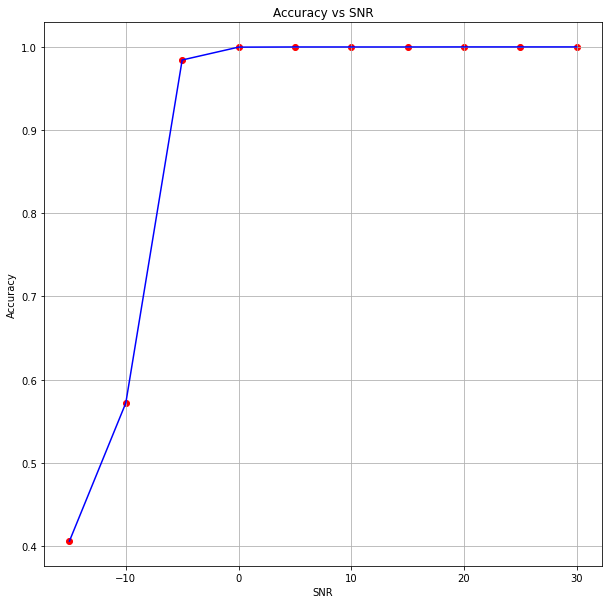

In [46]:
EvaluateData(CNNModel2, X_Train, y_Train, X_Valid, y_Valid, "../Results/CNN_Rayleigh_Accuracy_L=2.jpg")

### Rayleigh Fading of Channel Length = 3

Data Generation

In [47]:
X_Train, y_Train, X_Valid, y_Valid = ImportDatasets('Rayleigh',L=3)
X_Train = np.expand_dims(X_Train,axis=-1)
for snr in [-15,-10,-5,0,5,10,15,20,25]:
    X_Valid[snr] = np.expand_dims(X_Valid[snr],axis=-1)

Model Creation

In [48]:
CNNModel3 = CreateCNNModel()
CNNModel3.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100, 2, 1)]       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 98, 2, 64)         256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 96, 1, 16)         6160      
_________________________________________________________________
flatten (Flatten)            (None, 1536)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               196736    
_________________________________________________________________
dense_1 (Dense)              (None, 3)                 387       
Total params: 203,539
Trainable params: 203,539
Non-trainable params: 0
_______________________________________________________

Training

In [49]:
CNNModel3.fit(X_Train, y_Train, epochs=25, batch_size=16, validation_split=0.25,shuffle=True)

Epoch 1/25
704/704 [==============================] - 3s 4ms/step - loss: 0.3134 - acc: 0.8494 - val_loss: 0.0036 - val_acc: 1.0000
Epoch 2/25
704/704 [==============================] - 2s 3ms/step - loss: 0.0160 - acc: 0.9942 - val_loss: 0.0011 - val_acc: 1.0000
Epoch 3/25
704/704 [==============================] - 2s 3ms/step - loss: 0.0145 - acc: 0.9952 - val_loss: 0.0045 - val_acc: 0.9997
Epoch 4/25
704/704 [==============================] - 2s 3ms/step - loss: 0.0113 - acc: 0.9968 - val_loss: 3.1937e-04 - val_acc: 1.0000
Epoch 5/25
704/704 [==============================] - 2s 3ms/step - loss: 0.0049 - acc: 0.9985 - val_loss: 2.1164e-04 - val_acc: 1.0000
Epoch 6/25
704/704 [==============================] - 2s 3ms/step - loss: 9.7156e-04 - acc: 0.9999 - val_loss: 0.0038 - val_acc: 0.9992
Epoch 7/25
704/704 [==============================] - 2s 3ms/step - loss: 0.0031 - acc: 0.9989 - val_loss: 2.2342e-04 - val_acc: 1.0000
Epoch 8/25
704/704 [==============================] - 2s 4ms

Evaluating

Evaluating Model
469/469 [==============================] - 1s 2ms/step - loss: 123.3432 - acc: 0.3375
SNR: -15 Accuracy: 0.3375333249568939
469/469 [==============================] - 1s 2ms/step - loss: 49.7426 - acc: 0.3538
SNR: -10 Accuracy: 0.3537999987602234
469/469 [==============================] - 1s 2ms/step - loss: 13.0667 - acc: 0.4611
SNR: -5 Accuracy: 0.46106666326522827
469/469 [==============================] - 1s 2ms/step - loss: 1.3919 - acc: 0.9027
SNR: 0 Accuracy: 0.902733325958252
469/469 [==============================] - 1s 2ms/step - loss: 0.3493 - acc: 0.9699
SNR: 5 Accuracy: 0.9699333310127258
469/469 [==============================] - 1s 2ms/step - loss: 0.0634 - acc: 0.9913
SNR: 10 Accuracy: 0.9913333058357239
469/469 [==============================] - 1s 2ms/step - loss: 0.0124 - acc: 0.9979
SNR: 15 Accuracy: 0.9979333281517029
469/469 [==============================] - 1s 2ms/step - loss: 0.0071 - acc: 0.9984
SNR: 20 Accuracy: 0.9983999729156494
469/469 [==

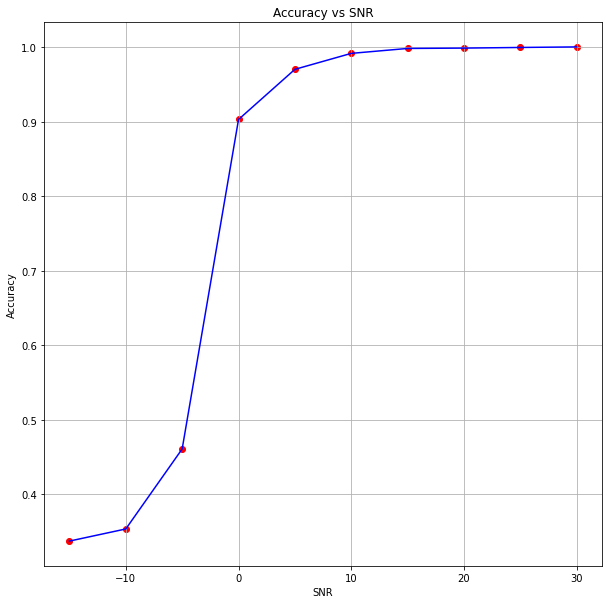

In [50]:
EvaluateData(CNNModel3, X_Train, y_Train, X_Valid, y_Valid, "../Results/CNN_Rayleigh_Accuracy_L=3.jpg")